<a id='top'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Predicting Nightly Mood Scores from Previously Submitted Mood
This notebook explores the affect that the previously reported mood has on the evening/later reported mood.

In [1]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data_import)
2. [Inspection](#inspection)
2. [Classification](#classification)

---

<a id='data_import'></a>

# Data Import
Data are simply imported from the Fitbit daily dataset and Fitbit sleep summary dataset - both of each include data summarized on a daily basis.

In [45]:
data = pd.read_csv("../data/interim/mood_prediction/beiwe-beiwe-ema_morning-ema_evening.csv",index_col=0)
data.replace("Very much",3,inplace=True)
data.head()

,timestamp_e,beiwe,content_e,stress_e,lonely_e,sad_e,energy_e,redcap,beacon,date,timestamp_m,content_m,stress_m,lonely_m,sad_m,energy_m,tst,sol,naw,restful
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13,2020-05-13 09:15:49,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13,2020-05-13 12:30:38,1,1.0,3.0,3.0,2.0,7.0,45.0,2.0,1.0
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13,2020-05-13 09:43:27,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13,2020-05-13 09:42:19,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13,2020-05-13 18:16:29,2,1.0,2.0,1.0,2.0,8.0,20.0,3.0,2.0


---

<a id='inspection'></a>

# Inspection
Doing some higher-level inspection of the data.

## Difference in Scores (Evening - Morning)
The simplest way to understand the difference in mood scores is to simply subtract them from one another. The more identical the scores, the greater the instance of zero.

In [135]:
def get_mood_difference(df_in,moods=["content","stress","lonely","sad","energy"],plot=False):
    """
    Calculates the score difference between mood scores ofthe same name.
    
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    moods : list-like, default ["content","stress","lonely","sad","energy"]
        Strings of the moods to consider - must be columns in df_in
    plot : boolean
        whether or not to output the histograms of the differences for each
        mood
        
    Returns
    -------
    df : DataFrame
        Original dataset with the mood scores removed and replaced with the 
        differences
    """
    df = df_in.copy()
    for mood in moods:
        df[f"{mood}_diff"] = pd.to_numeric(df[f"{mood}_e"]) - pd.to_numeric(df[f"{mood}_m"])
        
    df.drop([col for col in df.columns if col[-2:] in ["_e","_m"]],axis="columns",inplace=True)
    
    if plot:
        _, axes = plt.subplots(1,len(moods),figsize=(len(moods)*5,3),sharey=True)
        for i, (mood, ax) in enumerate(zip(moods,axes)):
            temp = pd.DataFrame(data=mood_diff[f"{mood}_diff"].value_counts())
            temp["percent"] = temp[f"{mood}_diff"] / temp[f"{mood}_diff"].sum()
            temp.sort_index(ascending=False,inplace=True)
            rects = ax.bar(temp.index,temp["percent"],edgecolor="black",color="lightgray")
            # x-axis
            if i == 4:
                ax.set_xlim([-4.5,4.5])
                ax.set_xticks(np.arange(-4,5,1))
            else:
                ax.set_xlim([-3.5,3.5])
                ax.set_xticks(np.arange(-3,4,1))
            if i == 2:
                ax.set_xlabel("Score Difference (E - M)")
            # y-axis
            ax.set_ylim([0,1])
            # remainder
            ax.set_title(mood.title())
            for score, height in zip(temp.index,temp["percent"]):
                ax.text(score,height+0.05,round(height*100,1),ha="center")
            
            
        axes[0].set_ylabel("Percent")
        plt.show()
        plt.close()
        
    return df

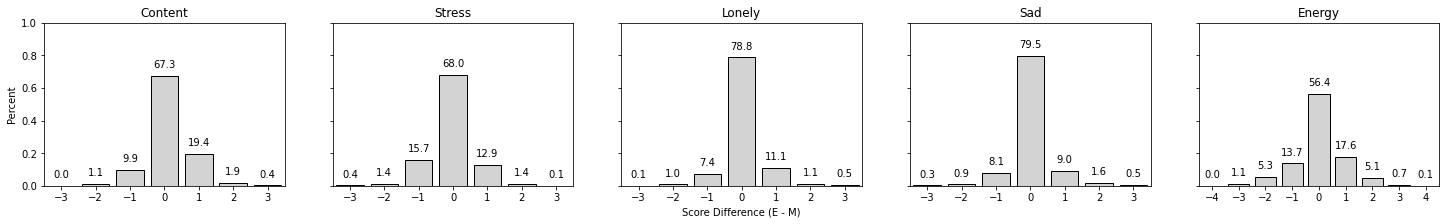

In [136]:
mood_diff = get_mood_difference(data,plot=True)

<div class="alert alert-block alert-info">
    
As expected, many of the differences between the mood scores are zero. This finding is less apparent when considering `energy` which makes sense since the energy of the participants should change. However, I would expect this change to be skewed towards a positive difference (indicating participants were _more_ tired in the evening) but that is not the case. Although they could have low energy in the mornings when they initially wake up. 
    
</div>

<div class="alert alert-block alert-info">
    
The maximum percentages also highlight a sort of upper bound on the accuracy of the model. Just like with our previous analysis, the model might be biased to simply report the same mood score since that is the most influential factor it seems.
    
</div>

---

<a id='classification'></a>

# Classification

In [97]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Bernoulli Naive Bayes
from sklearn.naive_bayes import GaussianNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Support Vector
from sklearn.svm import SVC
# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
# Logistic Regressions
from sklearn.linear_model import LogisticRegression

In [140]:
def get_x_and_y(df_in,mood="content"):
    """
    Gets the feature and target datasets corresponding to the target
    
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    mood : {"content","stress","lonely","sad","energy"}, default "content"
        Mood to consider - must be a column in df_in
        
    Returns
    -------
    X : array of floats
        Morning EMA mood reports
    y : list of floats
        Evening EMA mood reports corresponding to the input mood
    """
    df = df_in.copy()
    df.dropna(subset=[f"{mood}_e"],axis="rows",inplace=True)
    df.dropna(subset=[col for col in data.columns if col.endswith("_m") and col[:4] != "time"],axis="rows",inplace=True)
    X = df[[col for col in data.columns if col.endswith("_m") and col[:4] != "time"]].values
    y = df[f"{mood}_e"].values
    return X, y

## Comparing and Tuning Models
We test a slew of classification schemes to get the best model

### Defining Models and Hyperparameters to Tune
We use some common classifiers to predict the mood scores.

In [137]:
model_params = {
    "random_forest": {
        "model":RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators":[10,50,100],
            "max_depth":[1,2,3,4,5],
            "min_samples_split":[2,4],
            "min_samples_leaf":[1,2],
        }
    },
    "naive_bayes": {
        "model":GaussianNB(),
        "params": {
            
        }
    },
    "k-nearest_neighbor": {
        "model":KNeighborsClassifier(),
        "params": {
            "n_neighbors":[3,5,7],
            "weights":["uniform","distance"],
            "metric":["euclidean","manhattan","minkowski","jaccard","matching"],
            "p":[1,2],
        }
    },
    "svc": {
        "model": SVC(),
        "params": {
            "kernel":["linear","poly","sigmoid","rbf"],
        }
    },
    "gradientboost":{
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators":[10,50,100],
            "max_depth":[1,2,3,4,5],
            "min_samples_split":[2,4],
            "min_samples_leaf":[1,2],
        }
    },
    "logistic_regression": {
        "model":LogisticRegression(random_state=42,max_iter=500),
        "params": {
            "fit_intercept":[True,False],
            "solver":["lbfgs","liblinear"],
        }
    },
}

### Grid Search
Using our favorite, we examine the scores for using these models using 5-fold cross-validation

In [ ]:
agg_pred = ieq_and_sq_prediction()
agg_res = {"target":[],"best_performing_model":[],"model":[],"model_score":[],"biased_score":[],"hyper_parameters":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for target_set, targets in zip([fbsq,srsq],[["se","tst","light_percent","deep_percent","rem_percent"],["tst","sol","naw","restful"]]):
    for target in targets:
        agg_pred.run(ieq_activity_and_fb_select,target_set,target)
        for i in range(len(agg_pred.results)):
            agg_res["target"].append(target)
            agg_res["best_performing_model"].append(agg_pred.results.iloc[0,0])
            agg_res["model"].append(agg_pred.results.iloc[i,0])
            agg_res["model_score"].append(agg_pred.results.iloc[i,1])
            bs = sum(agg_pred.targets.values)/len(agg_pred.targets)
            agg_res["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
            agg_res["hyper_parameters"].append(agg_pred.results.iloc[i,2])
            try:
                agg_res["sensitive_parameter1"].append(agg_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
                agg_res["sensitive_parameter2"].append(agg_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
            except KeyError:
                agg_res["sensitive_parameter1"].append(np.nan)
                agg_res["sensitive_parameter2"].append(np.nan)

In [145]:
params = model_params
scores = []
for mood in ["content","stress","lonely","sad","energy"]:
    for model_name, mp in params.items():
        s = datetime.now()
        print(f"\t{model_name.replace('_',' ').title()}")
        clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
        X, y = get_x_and_y(data,mood="energy")
        clf.fit(X, y)
        scores.append({
            "mood":mood,
            "model":model_name,
            "best_score":clf.best_score_,
            "best_params":clf.best_params_
        })
        print("\t\tElapsed Time:\t", datetime.now() - s)
        print(f"\t\tBest Score:\t{round(clf.best_score_*100,1)}\n\t\tBest Params:\t{clf.best_params_}")

results = pd.DataFrame(scores,columns=["mood","model","best_score","best_params"])

	Random Forest
		Elapsed Time:	 0:00:24.451735
		Best Score:	55.4
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Naive Bayes
		Elapsed Time:	 0:00:00.019173
		Best Score:	45.1
		Best Params:	{}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:03.476047
		Best Score:	49.0
		Best Params:	{'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
	Svc
		Elapsed Time:	 0:00:05.227339
		Best Score:	55.6
		Best Params:	{'kernel': 'rbf'}
	Gradientboost
		Elapsed Time:	 0:01:35.136574
		Best Score:	56.7
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
	Logistic Regression
		Elapsed Time:	 0:00:00.716440
		Best Score:	52.4
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:25.091687
		Best Score:	55.4
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Naive Bayes
		Elapsed Time:	 0:00:00.027627

### Results from Model Comparison
The table below highlights the results from running the tests on all moods.

| Mood    | Naive | Random Forest | Naive Bayes | KNN  | SVC  | Gradient | Logistic Regression |
|---------|-------|---------------|-------------|------|------|----------|---------------------|
| Content | 67.3  | 67.1          | 56.6        | 63.3 | 67.4 | 67.5     | 67.3                |
| Stress  | 68.0  | 66.7          | 62.2        | 64.2 | 68.0 | 68.3     | 65.7                |
| Lonely  | 78.8  | 78.4          | 75.2        | 75.1 | 78.5 | 78.7     | 76.8                |
| Sad     | 79.5  | 78.9          | 76.4        | 78.2 | 78.3 | 79.2     | 78.2                |
| Energy  | 56.4  | 55.4          | 45.1        | 49.0 | 55.6 | 56.7     | 52.4                |

<div class="alert alert-block alert-info">
    
From this analysis, the models that we should consider are:
    
* Logistic Regression
* Support Vector
* Gradient Boost 
    
These models were the best-performing and operate on different principles which increases the diversity and strength of our results.
    
</div>

In [162]:
tuned_models = {"logistic_regression":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs"),
                "svc":SVC(kernel="rbf"),
                "gradient":GradientBoostingClassifier(random_state=42,n_estimators=100,max_depth=1,min_samples_leaf=2,min_samples_split=2)}

---

[Back to Top](#top)